**Image Reconstruction using Matrix Factorization and Linear Regression with RFF**

Importing Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import os
from einops import rearrange
from sklearn import preprocessing

Processing Functions

In [2]:
def mask_image_patch(img,x,y,z,patch_size):
    img_copy = img.clone()
    for i in range(patch_size):
        for j in range(patch_size):
                for k in range(z):
                    img_copy[x+i][y+j][k] = torch.nan
    return img_copy

def mask_image_random(img,patch_size):
    img_copy = img.clone()
    n = len(img)
    m = len(img[0])
    random_i = np.random.choice(n*m,patch_size*patch_size,replace=False)
    for i in random_i:
        for j in range(3):
            img_copy[i//n][i%m] = torch.nan
    return img_copy

def create_mask(t,x,y,patch_size):
    mask = torch.full(t.shape,True)
    z = t.shape[2]
    for i in range(patch_size):
        for j in range(patch_size):
                for k in range(z):
                    mask[x+i][y+j][k] = False
    return mask

def create_coordinate_map(img):
    height, width, num_channels = img.shape
    X = torch.empty((img.shape[0],img.shape[1],2))
    
    for i in range(height):
        for j in range(width):
            X[i][j][0] = i
            X[i][j][1] = j
    return X.reshape(-1,2)

def stack_itself(t, n):
    stacked_t = t.unsqueeze(1).expand(-1, n, -1)
    return stacked_t.squeeze()

def scale(img):
    img_flatted = img.reshape(-1,1)
    scaler_X = preprocessing.MinMaxScaler().fit(img_flatted)
    img_scaled = scaler_X.transform(img_flatted).reshape(img.shape)
    img_scaled = torch.tensor(img_scaled)
    img_scaled = img_scaled.float()
    return img_scaled

def fill_patch(original_img,reconstructed_img_patch,x,y,patch_size):
    reconstructed_img = original_img.clone()
    for i in range(patch_size):
        for j in range(patch_size):
                for k in range(3):
                    reconstructed_img[x+i][y+j][k] = reconstructed_img_patch[i][j][k]
    return reconstructed_img

Creating Dataset

In [3]:
img = torchvision.io.read_image('dog.jpg')
img_scaled = scale(img)
cropped_img = torchvision.transforms.functional.crop(img_scaled,600,800,300,300)
cropped_img = rearrange(cropped_img,'c h w -> h w c')
cropped_img = torch.tensor(cropped_img,dtype = torch.float32)
original_img = cropped_img.clone()

RuntimeError: [Errno 2] No such file or directory: 'dog.jpg'

Matrix Factorization

In [ ]:
def factorize_matrix(A, r):
    mask = ~torch.isnan(A)
    m,n = A.shape
    W = torch.rand(m,r,requires_grad=True)
    H = torch.rand(r,n,requires_grad=True)
    optimizer = optim.Adam([W,H],lr = 0.01)

    prev_loss = float('inf')  
    epsilon = 1e-6
    max_epochs = 1000

    for i in range(max_epochs):
        loss = torch.norm((A - torch.mm(W, H))[mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if abs(prev_loss - loss.item()) < epsilon:
            break
        prev_loss = loss.item()

    return W, H, loss

def image_reconstrunction_matrix_factorization(masked_img,r):
    W,H,loss = factorize_matrix(rearrange(masked_img, 'h w c -> h (w c)'), r)
    reconstructed_img = torch.mm(W,H).detach()
    reconstructed_img = reconstructed_img.reshape(masked_img.shape[0],masked_img.shape[1],masked_img.shape[2])

    # reconstructed_img = scale(reconstructed_img)
    return reconstructed_img

Linear Regression + RFF

In [ ]:
# LR + RFF
def plot_reconstructed_and_original_image(original_img, masked_img, reconstructed_img, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])

    ax0.imshow(reconstructed_img)
    ax0.set_title("Reconstructed Image")
    
    ax1.imshow(original_img.cpu())
    ax1.set_title("Original Image")

    ax2.imshow(masked_img.cpu())
    ax2.set_title("Masked Image")

    
    for a in [ax0, ax1, ax2]:
        a.axis("off")
    plt.show()

def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32)

def train(net, lr, X, Y, max_epochs=2000):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (known_pixels, 2) // (x,y)
    Y: torch.Tensor of shape (known_pixels, 3) // (r,g,b)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    outputs = net(X)
    loss = criterion(outputs, Y)
    
    prev_loss = float('inf')  
    epsilon = 1e-5
    prev_loss = float('inf')
    max_epochs = 10000
    
    for i in range(max_epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if abs(prev_loss - loss.item()) < epsilon:
            break
        prev_loss = loss.item()



class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)
    

def image_reconstrunction_linear_rff(original_img,masked_img):
    
    y = original_img.clone().reshape(-1,3)
    X = create_coordinate_map(original_img)
    mask = ~torch.isnan(masked_img).reshape(-1,3)
    X_train = X[mask[:,0:2]].reshape(-1,2)
    y_train = y[mask].reshape(-1,3)

    # Without RFF
    # net = LinearModel(2,3)
    # train(net,0.01,X_train,y_train,1000)
    # plot_reconstructed_and_original_image(original_img, net, X, title="Reconstructed Image")

    # With RFF
    features = 15000
    X_rff = create_rff_features(X, features, 0.008)
    mask_rff = stack_itself(mask[:,0].unsqueeze(1),features)
    X_rff_train = X_rff[mask_rff].reshape(-1,features)
    y_rff_train = y[mask].reshape(-1,3)

    
    netrff = LinearModel(X_rff_train.shape[1], 3)
    train(netrff, 0.005, X_rff_train, y_rff_train, 1000)
    height, width, num_channels = original_img.shape
    netrff.eval()
    with torch.no_grad():
        reconstructed_img = netrff(X_rff).reshape(height,width,num_channels)
    return reconstructed_img

Matrix Factorization using alternation Least Squares

In [ ]:
def imnvsdD

Data Compression

In [ ]:
def compress_patch(img_patch, r):
    W,H,loss = factorize_matrix(rearrange(img_patch, 'h w c -> h (w c)'), r)
    reconstructed_img = torch.mm(W,H).detach()
    reconstructed_img = reconstructed_img.reshape(img_patch.shape[0],img_patch.shape[1],img_patch.shape[2])

    # reconstructed_img = scale(reconstructed_img)
    return reconstructed_img

Metrics

In [ ]:
def mse(original_img,reconstructed_img):
    sum = torch.tensor(0)
    for i in range(3):
        sum = sum + (nn.functional.mse_loss(original_img[:,:,i],reconstructed_img[:,:,i]))
    return sum/3

In [ ]:
def psnr(original_img,reconstructed_img):
    psnr = torch.tensor(0)
    for i in range(3):
        maxi = torch.max(original_img[:,:,i])
        mse = nn.functional.mse_loss(original_img[:,:,i],reconstructed_img[:,:,i])
        psnr = psnr + (20*torch.log10(maxi/mse))
    return psnr/3

Reconstructions

Matrix Factorisation 30*30 rectangular patch


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


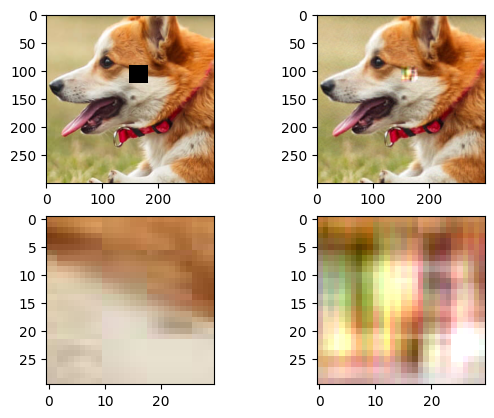

MSE for reconstruction :  tensor(0.0392)
PSNR for reconstruction :  tensor(27.1375)


In [ ]:
# 1a MF
patch_size = 30
# x_y_s = [[10,10,3],[90,150,3],[140,60,3]]
x_y_s = [[90,150,3]]
# titles = ["A. 1 color patch", "B. 2 color patch", "C. 5 color patch"]
title = "Matrix Factorisation 30*30 rectangular patch"
reconstructed_images_1 = []

for i in range(len(x_y_s)):
    print(title)
    masked_img = mask_image_patch(original_img,x_y_s[i][0],x_y_s[i][1],3,patch_size)
    reconstructed_img = image_reconstrunction_matrix_factorization(masked_img,100)
    reconstructed_images_1.append(reconstructed_img)
    mask = torch.isnan(masked_img)
    original_patch = original_img[mask].reshape(patch_size,patch_size,3)
    reconstructed_patch = reconstructed_img[mask].reshape(patch_size,patch_size,3)
    fig,axs = plt.subplots(2,2)
    axs[0][0].imshow(masked_img)
    axs[0][1].imshow(reconstructed_img)
    axs[1][0].imshow(original_patch)
    axs[1][1].imshow(reconstructed_patch)
    plt.show()
    print("MSE for reconstruction : ",mse(original_patch, reconstructed_patch))
    print("PSNR for reconstruction : ",psnr(original_patch, reconstructed_patch))

Linear Regression + RFF for 30*30 rectangular patch


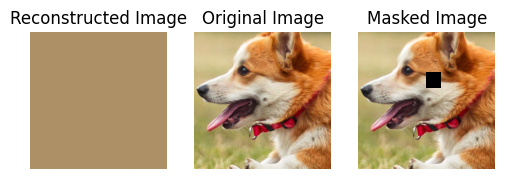

MSE for reconstruction :  tensor(0.0408)
PSNR for reconstruction :  tensor(27.9724)


In [ ]:
# 1a RFF
patch_size = 30
# x_y_s = [[10,10],[90,150],[140,60]]
x_y_s = [[90,150]]
reconstructed_images_2 = []

for i in range(len(x_y_s)):
    print("Linear Regression + RFF for 30*30 rectangular patch")
    masked_img = mask_image_patch(original_img,x_y_s[i][0],x_y_s[i][1],3,patch_size)
    reconstructed_img = image_reconstrunction_linear_rff(original_img,masked_img)
    reconstructed_images_2.append(reconstructed_img)
    plot_reconstructed_and_original_image(original_img, masked_img, reconstructed_img, title="Reconstructed Image with RFF Features")
    print("MSE for reconstruction : ",mse(original_img, reconstructed_img))
    print("PSNR for reconstruction : ",psnr(original_img, reconstructed_img))

Random Missing pixels MF


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


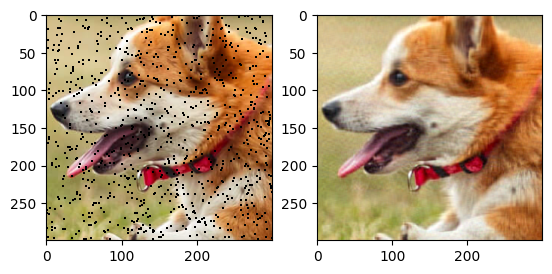

MSE for reconstruction :  tensor(0.0006)
PSNR for reconstruction :  tensor(64.7207)


In [ ]:
# 1b MF

patch_size = 30
titles = ["Random Missing pixels MF"]
reconstructed_images_3 = []

print(titles[0])
masked_img = mask_image_random(original_img, patch_size)
reconstructed_img = image_reconstrunction_matrix_factorization(masked_img,50)
reconstructed_images_3.append(reconstructed_img)
fig,axs = plt.subplots(1,2)
axs[0].imshow(masked_img)
axs[1].imshow(reconstructed_img)
plt.show()
print("MSE for reconstruction : ",mse(original_img, reconstructed_img))
print("PSNR for reconstruction : ",psnr(original_img, reconstructed_img))

Random Missing pixels RFF


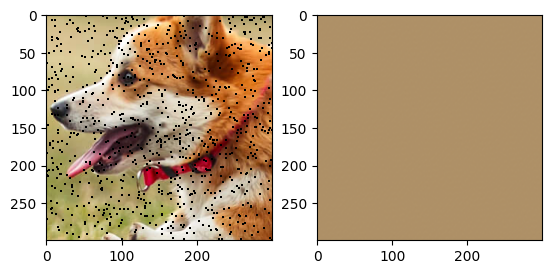

MSE for reconstruction :  tensor(0.0408)
PSNR for reconstruction :  tensor(27.9749)


In [ ]:
# 1b RFF
patch_size = 30
titles = ["Random Missing pixels RFF"]
reconstructed_images_4 = []

print(titles[0])
masked_img = mask_image_random(original_img, patch_size)
reconstructed_img = image_reconstrunction_linear_rff(original_img, masked_img)
reconstructed_images_4.append(reconstructed_img)
fig,axs = plt.subplots(1,2)
axs[0].imshow(masked_img)
axs[1].imshow(reconstructed_img)
plt.show()
print("MSE for reconstruction : ",mse(original_img, reconstructed_img))
print("PSNR for reconstruction : ",psnr(original_img, reconstructed_img))

We can see, we get better reconstruction using Linear Regression than Matrix Factorization

Patch Size  : 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


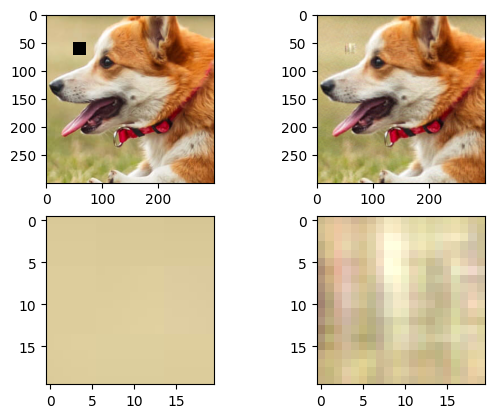

MSE for reconstruction :  tensor(0.0003)
PSNR for reconstruction :  tensor(69.3436)
Patch Size  : 40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


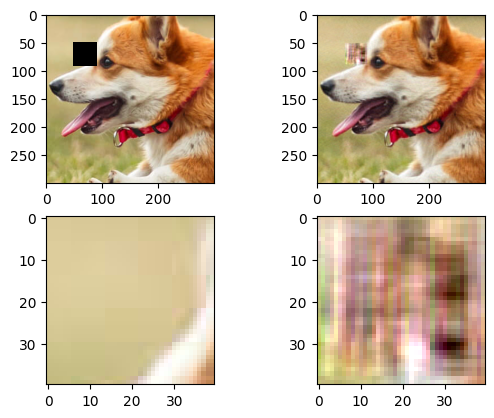

MSE for reconstruction :  tensor(0.0012)
PSNR for reconstruction :  tensor(58.3389)
Patch Size  : 60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


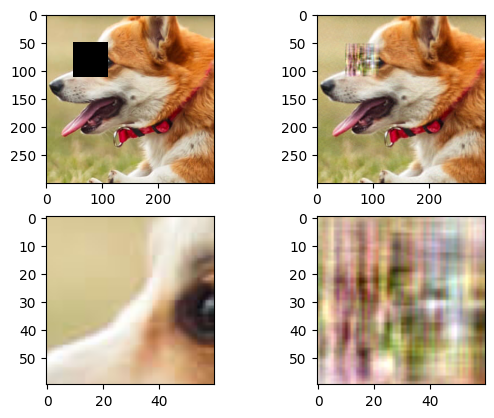

MSE for reconstruction :  tensor(0.0031)
PSNR for reconstruction :  tensor(50.1359)
Patch Size  : 80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


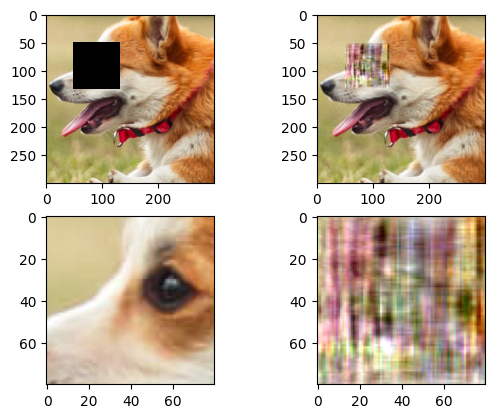

MSE for reconstruction :  tensor(0.0046)
PSNR for reconstruction :  tensor(46.7653)
Patch Size  : 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


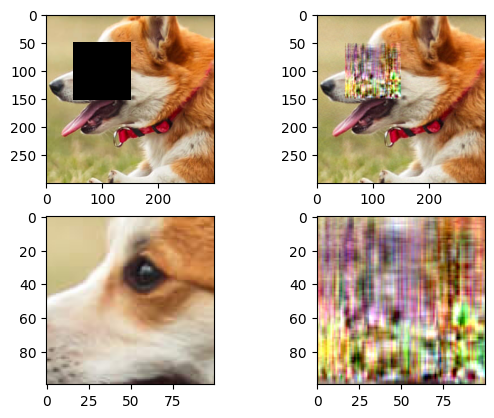

MSE for reconstruction :  tensor(0.0089)
PSNR for reconstruction :  tensor(41.0268)


Text(0, 0.5, 'MSE for reconstruction')

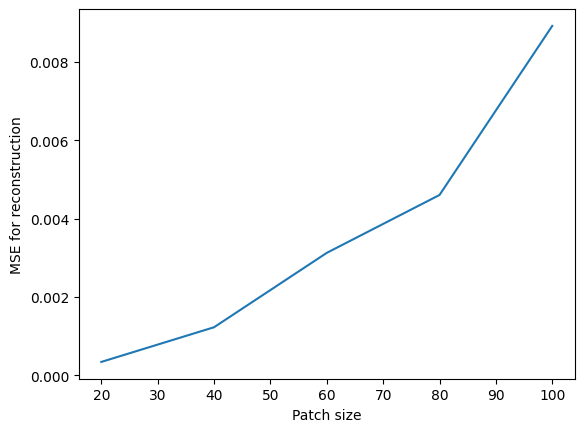

In [ ]:
# 2a MF

x_start = 50
y_start = 50
patch_sizes = [20,40,60,80,100]
reconstructed_images_5 = []
mses= []
psnrs = []

for i in range(len(patch_sizes)):
    print("---------------------------")
    print(f"Patch Size  : {patch_sizes[i]}")
    patch_size = patch_sizes[i]
    masked_img = mask_image_patch(original_img,x_start,y_start,3,patch_sizes[i])
    reconstructed_img = image_reconstrunction_matrix_factorization(masked_img,100)
    reconstructed_images_5.append(reconstructed_img)
    mask = torch.isnan(masked_img)
    fig,axs = plt.subplots(2,2)
    axs[0][0].imshow(masked_img)
    axs[0][1].imshow(reconstructed_img)
    axs[1][0].imshow(original_img[mask].reshape(patch_size,patch_size,3))
    axs[1][1].imshow(reconstructed_img[mask].reshape(patch_size,patch_size,3))
    plt.show()
    ms = mse(original_img, reconstructed_img)
    ps = psnr(original_img, reconstructed_img)
    mses.append(ms)
    psnrs.append(ps)
    print("MSE for reconstruction : ",ms)
    print("PSNR for reconstruction : ",ps)
    print("---------------------------")

print("---------------------------")
plt.plot(patch_sizes,mses)
plt.xlabel("Patch size")
plt.ylabel("MSE for reconstruction")
print("---------------------------")

Patch Size  : 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


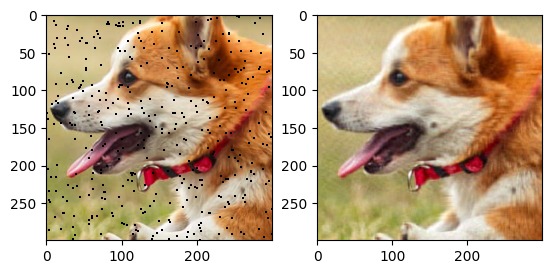

MSE for reconstruction :  tensor(0.0006)
PSNR for reconstruction :  tensor(64.4843)
Patch Size  : 40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


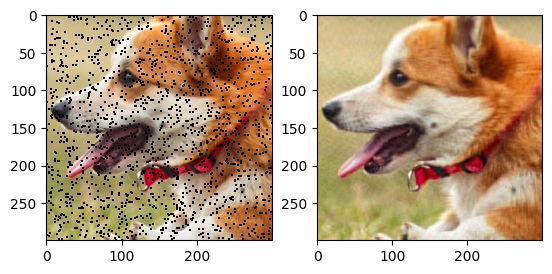

MSE for reconstruction :  tensor(0.0006)
PSNR for reconstruction :  tensor(64.6533)
Patch Size  : 60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


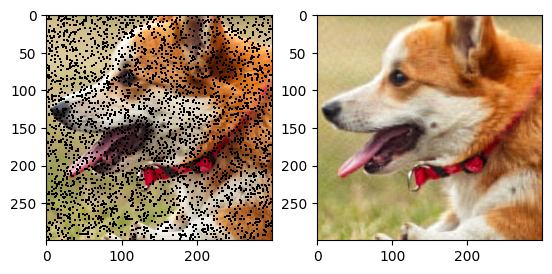

MSE for reconstruction :  tensor(0.0006)
PSNR for reconstruction :  tensor(64.5290)
Patch Size  : 80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


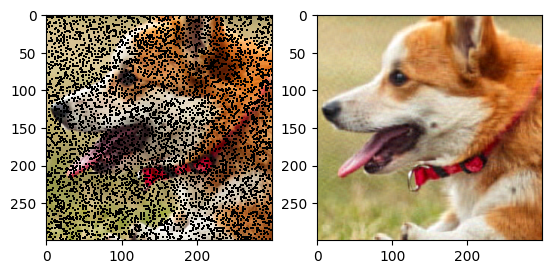

MSE for reconstruction :  tensor(0.0006)
PSNR for reconstruction :  tensor(64.4017)
Patch Size  : 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


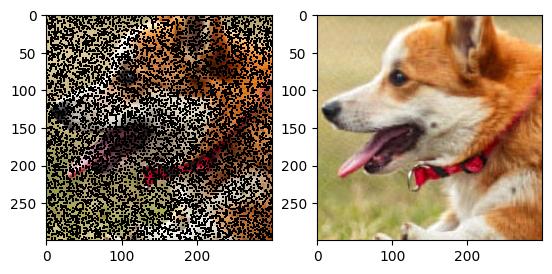

MSE for reconstruction :  tensor(0.0006)
PSNR for reconstruction :  tensor(64.2192)


Text(0, 0.5, 'MSE for reconstruction')

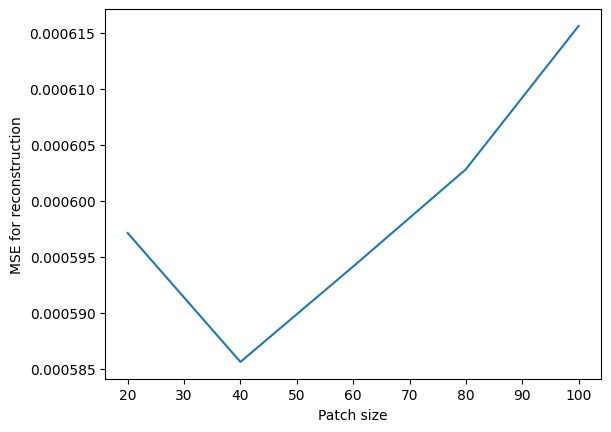

In [ ]:
# 2b MF
x_start = 50
y_start = 50
# n1 = [30]
patch_sizes = [20,40,60,80,100]
reconstructed_images_6 = []
mses = []
psnrs = []

for i in range(len(patch_sizes)):
    print("---------------------------")
    print(f"Patch Size  : {patch_sizes[i]}")
    masked_img = mask_image_random(original_img,patch_sizes[i])
    reconstructed_img = image_reconstrunction_matrix_factorization(masked_img,50)
    reconstructed_images_6.append(reconstructed_img)
    fig,axs = plt.subplots(1,2)
    axs[0].imshow(masked_img)
    axs[1].imshow(reconstructed_img)
    plt.show()
    ms = mse(original_img, reconstructed_img)
    ps = psnr(original_img, reconstructed_img)
    mses.append(ms)
    psnrs.append(ps)
    print("MSE for reconstruction : ",ms)
    print("PSNR for reconstruction : ",ps)
    print("---------------------------")

print("---------------------------")
plt.plot(patch_sizes,mses)
plt.xlabel("Patch size")
plt.ylabel("MSE for reconstruction")
plt.show()
print("---------------------------")

Increase RFF from 100 to 37500 in create_rff_features function !!

Reconstuctions using Matrix Factorization with Linear Regression

Data Compression Reconstructions

---------------------------
A. 1 color patch
r :  5


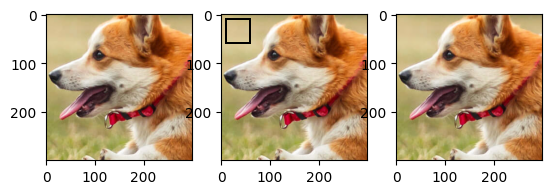

MSE for reconstruction :  tensor(9.0075e-06)
PSNR for reconstruction :  tensor(98.7038)
r :  5


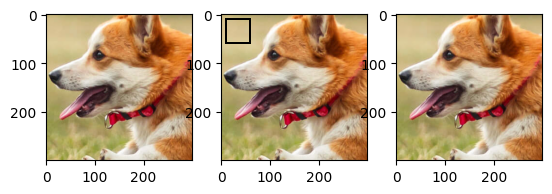

MSE for reconstruction :  tensor(8.2049e-06)
PSNR for reconstruction :  tensor(99.4319)
r :  5


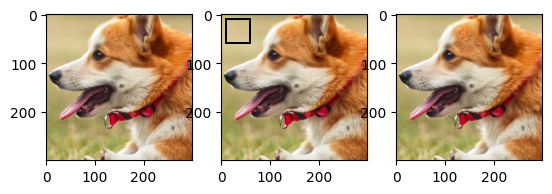

MSE for reconstruction :  tensor(1.1276e-05)
PSNR for reconstruction :  tensor(96.7274)
r :  5


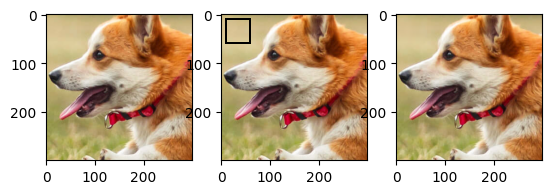

MSE for reconstruction :  tensor(1.5145e-05)
PSNR for reconstruction :  tensor(94.4311)
---------------------------
---------------------------
B. 2 color patch
r :  10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


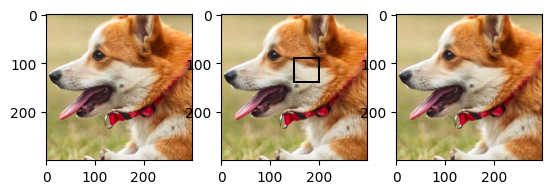

MSE for reconstruction :  tensor(0.0001)
PSNR for reconstruction :  tensor(77.1598)
r :  10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


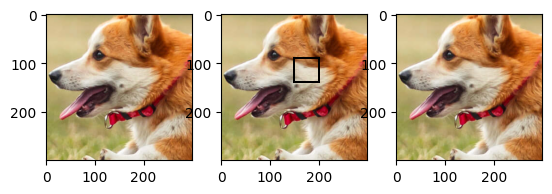

MSE for reconstruction :  tensor(0.0001)
PSNR for reconstruction :  tensor(76.9132)
r :  10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


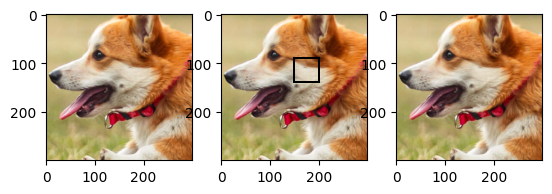

MSE for reconstruction :  tensor(0.0001)
PSNR for reconstruction :  tensor(77.2323)
r :  10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


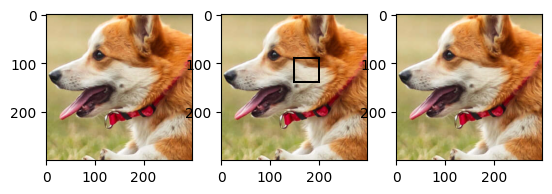

MSE for reconstruction :  tensor(0.0001)
PSNR for reconstruction :  tensor(77.2195)
---------------------------
---------------------------
C. 5 color patch
r :  25


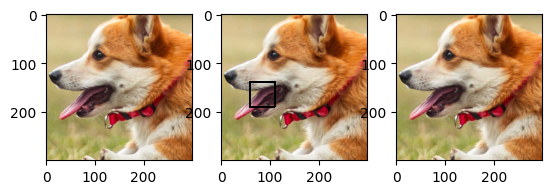

MSE for reconstruction :  tensor(3.8247e-05)
PSNR for reconstruction :  tensor(87.4174)
r :  25


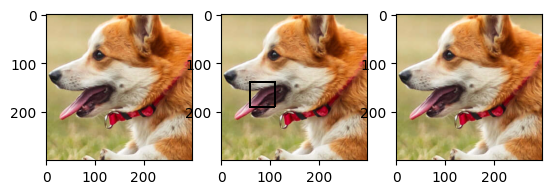

MSE for reconstruction :  tensor(3.7595e-05)
PSNR for reconstruction :  tensor(87.5620)
r :  25


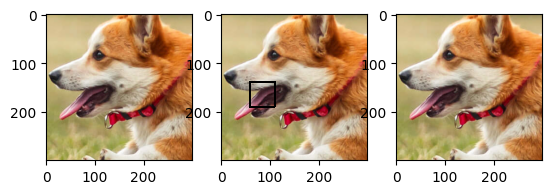

MSE for reconstruction :  tensor(2.9234e-05)
PSNR for reconstruction :  tensor(89.7409)
r :  25


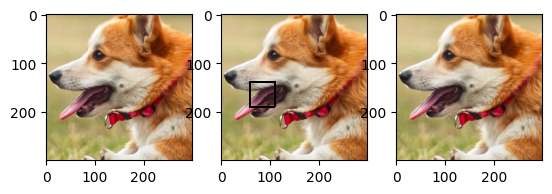

MSE for reconstruction :  tensor(2.9827e-05)
PSNR for reconstruction :  tensor(89.5737)
---------------------------


In [ ]:
patch_size = 50
x_y_s = [[10,10],[90,150],[140,60]]
rs = [5, 10, 25, 50]
titles = ["A. 1 color patch", "B. 2 color patch", "C. 5 color patch"]

def border_patch(original_img,x,y,patch_size):
    bordered_img = original_img.clone()
    for i in range(patch_size):
        for k in range(3):
            bordered_img[x+i][y][k] = torch.nan 
            bordered_img[x+i][y+patch_size][k] = torch.nan 

    for j in range(patch_size):
        for k in range(3):
            bordered_img[x][y+j][k] = torch.nan 
            bordered_img[x+patch_size][y+j][k] = torch.nan 

    return bordered_img

mses = np.empty((len(x_y_s),len(rs)))
pses = np.empty((len(x_y_s),len(rs)))

for i in range(len(x_y_s)):
    print("---------------------------")
    print(titles[i])
    for j in range(len(rs)):
        print("r : ",rs[j])
        mask = create_mask(original_img, x_y_s[i][0], x_y_s[i][1],patch_size)
        img_patch = original_img[~mask].reshape(patch_size,patch_size,3)
        reconstructed_img_patch  = image_reconstrunction_matrix_factorization(img_patch,rs[j])
        reconstructed_img = fill_patch(original_img,reconstructed_img_patch,x_y_s[i][0],x_y_s[i][1],patch_size)
        fig,axs = plt.subplots(1,3)
        axs[0].imshow(original_img)
        axs[1].imshow(border_patch(original_img,x_y_s[i][0],x_y_s[i][1],patch_size))
        axs[2].imshow(reconstructed_img)
        plt.show()
        ms = mse(img_patch, reconstructed_img_patch)
        ps = psnr(img_patch, reconstructed_img_patch)
        print("MSE for reconstruction : ",ms)
        print("PSNR for reconstruction : ",ps)
        mses[i][j] = ms
        pses[i][j] = ps
    print("---------------------------")


In [ ]:
print("MSE for Different Cases")
mse_dataframe = pd.DataFrame(mses,index = ['1 color','2 colors','5 colors'],columns = rs)
mse_dataframe

MSE for Different Cases


5         10        25        50
1 color   0.000009  0.000008  0.000011  0.000015
2 colors  0.000123  0.000126  0.000122  0.000122
5 colors  0.000038  0.000038  0.000029  0.000030